## Save four metrics in pandas dataframe 

- Accuracy
- Precision
- Recall
- F1

In [1]:
from os import listdir, walk
from os.path import isfile, join
import numpy as np
import pandas as pd

In [3]:
def get_filenames_from_dir(file_dir, include_sub_dir=False):
    if include_sub_dir:
        filenames = []
        for root, _, files in walk(file_dir, topdown=False):
            for f in files:
                if f != '.DS_Store':
                    filenames.append(join(root, f).replace(file_dir + "/", ""))
    else:
        filenames = [f for f in listdir(file_dir) if isfile(join(file_dir, f)) and f != '.DS_Store']
        
    return filenames


filenames = get_filenames_from_dir('../data/ablation_tests_pred')


def parseMetaData(filename):    
    items = filename.split('_')
    if len(items) == 4:
        return ['base', 'NONE', items[-2], items[1]]
    elif len(items) == 6:
        return ['reda', items[2].upper(), items[-2], items[1]]
    elif len(items) == 7:
        return ['reda_ngram', items[2].upper(), items[-2], items[1]]
    else:
        raise NameError("The file's name appears to be wrong")
        
        
def get_accu_pre_recall_f1(filename, dire='../data/ablation_tests_pred/'):
    file = open(dire + filename)
    first_line = next(file)
    accu = float(first_line.strip().split(': ')[-1])
    # get rid of two unrelated lines
    next(file)
    next(file)
    tp, fp, tn, fn = 0, 0, 0, 0
    
    for line in file:
        line = line.strip().split('\t')
        i, j = int(line[3]), int(line[2])
        if i == 1 and j == 1:
            tp += 1
        elif i == 1 and j == 0:
            fp += 1
        elif i == 0 and j == 0:
            tn += 1
        else:
            fn += 1
            
    P = round(tp / (tp + fp), 3)
    R = round(tp / (tp + fn), 3)
    F1 = round(2 * P * R / (P + R), 3)
    return [accu, P, R, F1]


def get_data():
    data = []
    for fn in filenames:
        data.append(parseMetaData(fn) + get_accu_pre_recall_f1(fn))
        
    return data

In [4]:
data = get_data()
columns = ['TrainType', 'EditType', 'ClfModel', 'TrainSize', 'Accuracy', 'Precision', 'Recall', 'F1']
df = pd.DataFrame(data, columns=columns)
df.to_excel('/users/wzx/Downloads/ablation_data.xlsx', index=False)

## Plotting

In [5]:
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

In [6]:
def plot(dataFrame, nrow=2, ncol=3, metric='Accuracy', include_ernie=True, save=True):
    if not include_ernie:
        dataFrame = dataFrame[dataFrame['ClfModel'] != 'ernieGram']
        suffix = '_ernieExcluded'
    else:
        suffix = ''
        
    fig = plt.figure(figsize=(10,4))
    fig.subplots_adjust(hspace=1, wspace=0.5)
    base_total, reda_total, ngram_total = [], [], []
    data_sizes = ['5k', '10k', '25k', '50k', '75k', '100k', 
              '125k', '150k', '175k', '200k', 'full']
    pos = list(range(1, len(data_sizes) + 1))
    
    for i, edit in enumerate(['SR', 'RS', 'RI', 'RD', 'RM']):
        ax = fig.add_subplot(nrow, ncol, i + 1)
        subdf = dataFrame[dataFrame['EditType'] == edit]
        scores = []
        base = dataFrame[dataFrame['TrainType'] == 'base']
        reda = subdf[subdf['TrainType'] == 'reda']
        ngram = subdf[subdf['TrainType'] == 'reda_ngram']
        base_scores, reda_scores, ngram_scores = [], [], []
    
        for size in data_sizes:
            b = base[base['TrainSize'] == size]
            base_scores.append(round(np.mean(b[metric]), 3))
            base_total.append(base_scores)
            r = reda[reda['TrainSize'] == size]
            reda_scores.append(round(np.mean(r[metric]), 3))
            reda_total.append(reda_scores)
            n = ngram[ngram['TrainSize'] == size]
            ngram_scores.append(round(np.mean(n[metric]), 3))
            ngram_total.append(ngram_scores)
    
        ax.plot(data_sizes, base_scores, linestyle='-', linewidth=1.5, marker='o', markersize=2, c='b', label='baseline')
        ax.plot(data_sizes, reda_scores, linestyle='-', linewidth=1.5, marker='o', markersize=2, c='orange', label='reda')
        ax.plot(data_sizes, ngram_scores, linestyle='-', linewidth=1.5, marker='o',markersize=2, c='g', label='reda_ngram')
        
        ticks_loc = ax.get_xticks()
        ax.xaxis.set_ticks(ticks_loc)
        ax.set_xticklabels(labels=data_sizes, rotation=55, fontsize=6)        
        y = [round(i, 2) for i in ax.get_yticks()]
        ax.yaxis.set_ticks(y)
        y = [format(i, ".2f") for i in y]
        ax.set_yticklabels(labels=y, fontsize=6)
        
        ax.set_title(edit)
        ax.set_xlabel('Data Size', fontsize=10)
        ax.set_ylabel(metric, fontsize=10)
        ax.legend(fontsize=5, loc='lower right')
    
    ax = fig.add_subplot(nrow, ncol, 6)
    base_total, reda_total, ngram_total = np.array(base_total), np.array(reda_total), np.array(ngram_total)
    base_avg, reda_avg, ngram_avg = np.mean(base_total, axis=0), np.mean(reda_total, axis=0), np.mean(ngram_total, axis=0)
    ax.plot(data_sizes, base_avg, linestyle='-', linewidth=1.5, marker='o', markersize=2, c='b', label='baseline')
    ax.plot(data_sizes, reda_avg, linestyle='-', linewidth=1.5, marker='o', markersize=2, c='orange', label='reda')
    ax.plot(data_sizes, ngram_avg, linestyle='-', linewidth=1.5, marker='o', markersize=2, c='g', label='reda_ngram')
    
    ticks_loc = ax.get_xticks()
    ax.xaxis.set_ticks(ticks_loc)
    ax.set_xticklabels(labels=data_sizes, rotation=55, fontsize=6)
    y = [round(i, 2) for i in ax.get_yticks()]
    ax.yaxis.set_ticks(y)
    y = [format(i, ".2f") for i in y]
    ax.set_yticklabels(labels=y, fontsize=6)
    
    ax.set_title('Average')
    ax.set_xlabel('Data Size', fontsize=10)
    ax.set_ylabel(metric, fontsize=10)
    ax.legend(fontsize=5, loc='lower right')
    
    if save:
        plt.savefig(f'/users/wzx/Downloads/ablation_{metric.lower()}{suffix}.png', dpi=300, bbox_inches='tight')

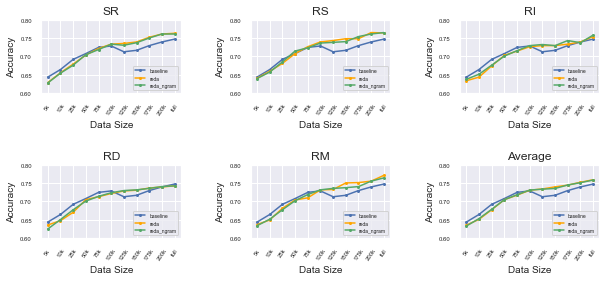

In [7]:
plot(df)

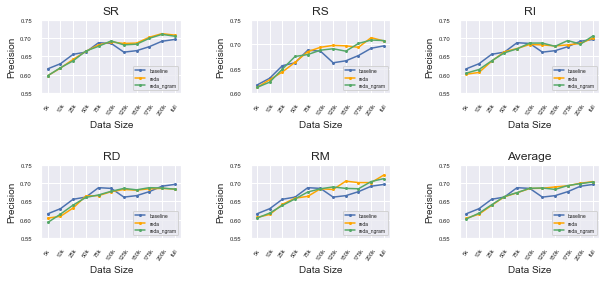

In [8]:
plot(df, metric='Precision')

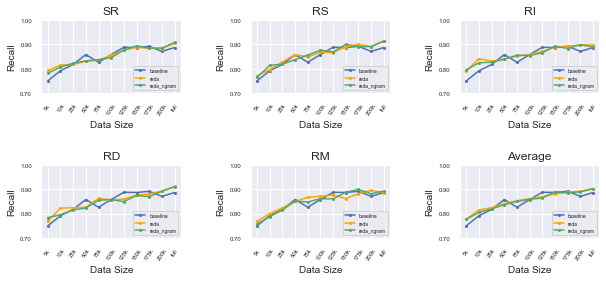

In [9]:
plot(df, metric='Recall')

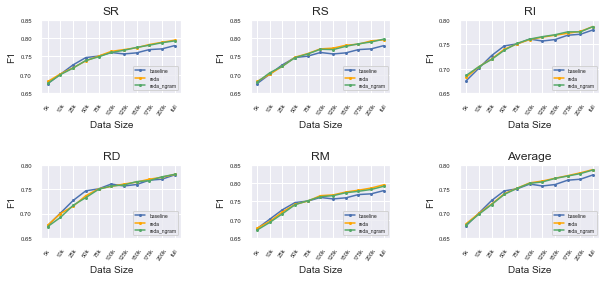

In [10]:
plot(df, metric='F1')

### Plot without ernieGram models

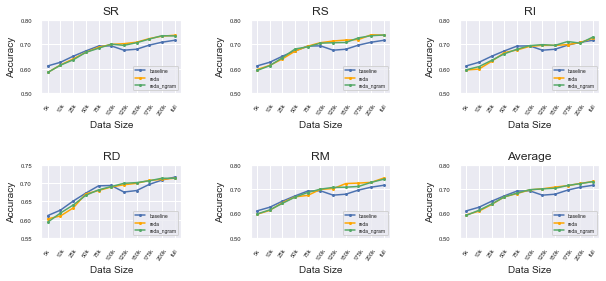

In [11]:
plot(df, include_ernie=False)

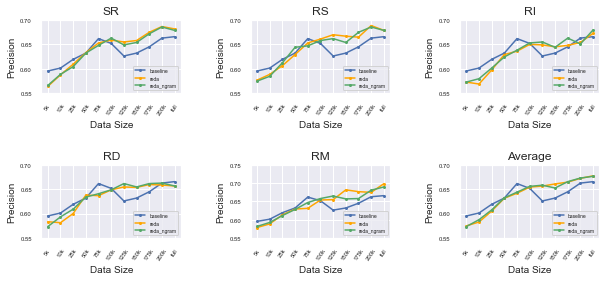

In [12]:
plot(df, metric='Precision', include_ernie=False)

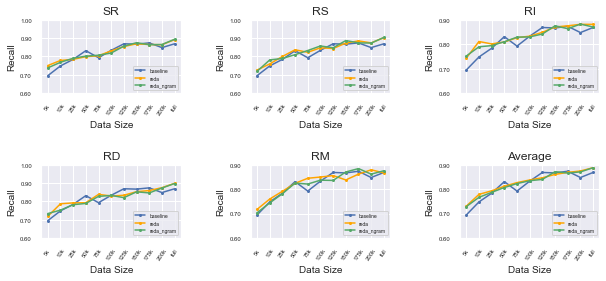

In [13]:
plot(df, metric='Recall', include_ernie=False)

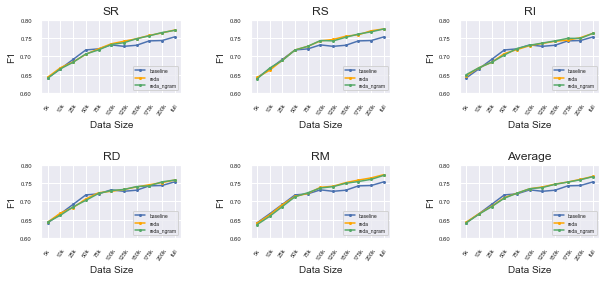

In [14]:
plot(df, metric='F1', include_ernie=False)